In [1]:
from scipy.optimize import curve_fit
from scipy.interpolate import BarycentricInterpolator
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from tabulate import tabulate
import time

# Primeiro exercício

In [2]:
#Função f(x)= 1
def cte_1(x):
    return 1

In [3]:
#Função que calcula f(x) = x
def x_func(x):
    return x

In [4]:
#Função que calcula f(x) = x^2
def x_square(x):
    return x**2

In [5]:
#Função que calcula f(x) = ln(x)
def log(x):
    return np.log(x)

In [6]:
#Função que calcula f(x) = \sum_i \alpha_i f_i(x)
def f(x,alpha,*func):
    result = 0
    for i,j in enumerate(func):
        result += alpha[i]*j(x)
    return result

In [7]:
#função que calcula o braket entre f_i e f_j
def bracket_fi_fj(x,f_i,f_j):
    bracket = 0
    for k in x:
        bracket += f_i(k)*f_j(k)
    return bracket

In [8]:
#Função que calcula o braket entre f_i e y
def bracket_fi_y(x,y,f_i):
    bracket = 0
    for i,k in enumerate(x):
        bracket += f_i(k)*y[i]
    return bracket
    

In [9]:
#Função que gera a matrix de brakets que vair ser nossa matriz de coeficientes para aplicarmos no método de eliminação de Gauss
def coef_matrix(x,n_param,funcs):
    matrix = [([0]*n_param) for i in range(n_param)]
    for i in range(n_param):
        for j in range(i,n_param):
            matrix[i][j] = matrix[j][i] = bracket_fi_fj(x,funcs[i],funcs[j])
    
    return matrix

In [10]:
#Vetor que fica do lado direito da igualdade do sistema (brakets f_i y)
def equal_vector(x,y,n_param,funcs):
    vector = []
    for i in range(n_param):
        vector.append(bracket_fi_y(x,y,funcs[i]))
    return vector

In [11]:
#Função responsável por resolver o sistema pelo método de eliminação de Gauss
def eliminacaoGauss(A, y, m, print_a = False, print_y = False):
  # 1ª parte (escalonamento na forma triangular superior)
    for j in range(0,m):
        k=j+1
        if (A[j][j] == 0):
            while (k!=m-1):
                if (A[k][j] != 0):
                    #Troca X
                    aux = A[k]
                    A[k] = A[j]
                    A[j] = aux
                    #Troca Y
                    aux = y[j]
                    y[j] = y[k]
                    y[k] = aux
                    print("Troca:",A) 
                    break
                elif(k==m-1):
                    print("Erro: A matriz A é singular")
                    return
                else:
                    k+=1
        
        for i in range(j+1,m):
            mu = -A[i][j]/A[j][j]
            y[i] = y[i]+mu*y[j]
            for l in range(j,m):
                A[i][l] = A[i][l]+mu*A[j][l]
    if print_a:
        print(A)
    if print_y:    
        print(y)
        
# 2ª parte (substituição)
    x= np.zeros(m)
    
    
    x[m-1] = y[m-1]/A[m-1][m-1]
    for i in range(m-2,-1, -1):
        x[i] = y[i]
        for k in range(i+1,m):
            x[i] = x[i]-A[i][k]*x[k]
        x[i] = x[i]/A[i][i]
    return x

##### Funções utilizadas no segundo exercício

In [12]:
#Função responsável por calcular a integral via método dos trapézios
def trapezoidal_rule(a,b,m,func):
    h = (b-a)/m
    t_m = 0.5*(func(a)+func(b))
    for i in range(1,m):
        x_i = a + i*h
        t_m = t_m + func(x_i)
        
    return t_m*h

In [13]:
#Função e^x
def exp(x):
    return np.exp(x)

In [14]:
#Função que executa o algoritmo de diferenças divididas de Newton
def dvd_diff(x,y):
    k = len(x)
    m = np.zeros((k,k))
    
    for j in range(k):
        for i in range(k-j):
            if j == 0:
                m[i][j] = y[i]
            else:
                m[i][j] = (m[i+1][j-1] - m[i][j-1])/(x[i+j] - x[i])
    return m   

In [15]:
#Esta função calcula a integral da função através do método de Romberg a partir dos dados x_i = (2^i h)^2 e y_i = T(2^i h),
#onde T(h) é a integral calculada via método dos trapézios
def romberg_integral(x,y,print_coef = False):
    #Gerando a matriz cuja primeira linha contém os coeficientes do polinômio
    matrix = dvd_diff(x,y)
    
    #Calculando o valor do polinômio no ponto x = 0:
    integral = 0
    prod_x = 1
    for i,m in enumerate(matrix[0]):
        integral += m*prod_x
        prod_x = prod_x*(-x[i])
        
    #Condicional para verificar se queremos imprimir os coeficientes do polinômio interpolador
    if print_coef == True:
        return integral, matrix[0]
    
    else:
        return integral

In [16]:
#Função que calcula a integral pelo método de Simpson
def simpson_integral(a,b,m,func):
    integral = func(a) + func(b)
    h = (b-a)/m
    for i in range(1,m):
        x_i = a+i*h
        if (i % 2 == 0):
            integral += 2*func(x_i)
        else:
            integral += 4*func(x_i)
        
    return h*integral/3

In [17]:
#Função que calcula f(x) = x^20
def x_powerof20(x):
    return x**20

In [18]:
#Função que calcula f(x) = \sqrt{x} * \ln{x}
def x_sqrtlog(x):
    if(x==0):
        return 0
    return np.sqrt(x) * np.log(x)

#### Fim das funções

In [19]:
#Dados

#Profundidade em metros
#x antes de arrumar o erro em i=10: x = [10.4,11.7,12.8,13,15.7,16.3,18,18.7,20.7,22.1,122.4,24.4,25.8,32.5,33.6,36.8,37.8,36.9,42.2,47,47.1,48.4,49.4,49.5,59.2,60.1,61.7,62.4,69.3,73.6,74.4,78.5,82.9,87.7,88.1,90.4,90.6,97.7,103.7]
#x com o valor certo para i=10
x = [10.4,11.7,12.8,13,15.7,16.3,18,18.7,20.7,22.1,22.4,24.4,25.8,32.5,33.6,36.8,37.8,36.9,42.2,47,47.1,48.4,49.4,49.5,59.2,60.1,61.7,62.4,69.3,73.6,74.4,78.5,82.9,87.7,88.1,90.4,90.6,97.7,103.7]

#Porcentagem de lodo para uma profundidade x
y = [19.5,24.9,36.1,40.9,26.5,32.2,55.3,36.8,54.4,41.5,27.8,29,53.6,69.8,43.1,52.7,50.7,47.4,50.4,45.1,53.5,48,55.4,54.7,45.2,52.7,46.9,49.7,44.9,51.6,49.5,48.5,52.1,47.3,45.6,48.9,53.8,48.0,47.8]

In [20]:
#Funções a serem ajustadas
funcs = [cte_1,x_func,x_square,log]

#Matriz de coeficientes
coef_mat = coef_matrix(x,4,funcs)

#Lado direito da igualdade
equal_vec = equal_vector(x,y,4,funcs)

#Variáveis a serem determinadas
alpha = eliminacaoGauss(coef_mat, equal_vec, 4)

#Gerando um vetor de index
index = [i for i in range(1,5)]

#Exibindo a tabela contendo o resultado do método de MMQ
print(tabulate([np.append(['alpha_i'],alpha)],headers = np.append(['i'],index),tablefmt='grid',numalign="center", floatfmt = ".17f"))

+---------+-----------------------+----------------------+---------------------+----------------------+
| i       |           1           |          2           |          3          |          4           |
+=========+=======================+======================+=====================+======================+
| alpha_i | -73.30266690299747268 | -1.59064586200516112 | 0.00588032325400866 | 48.30010153809588758 |
+---------+-----------------------+----------------------+---------------------+----------------------+


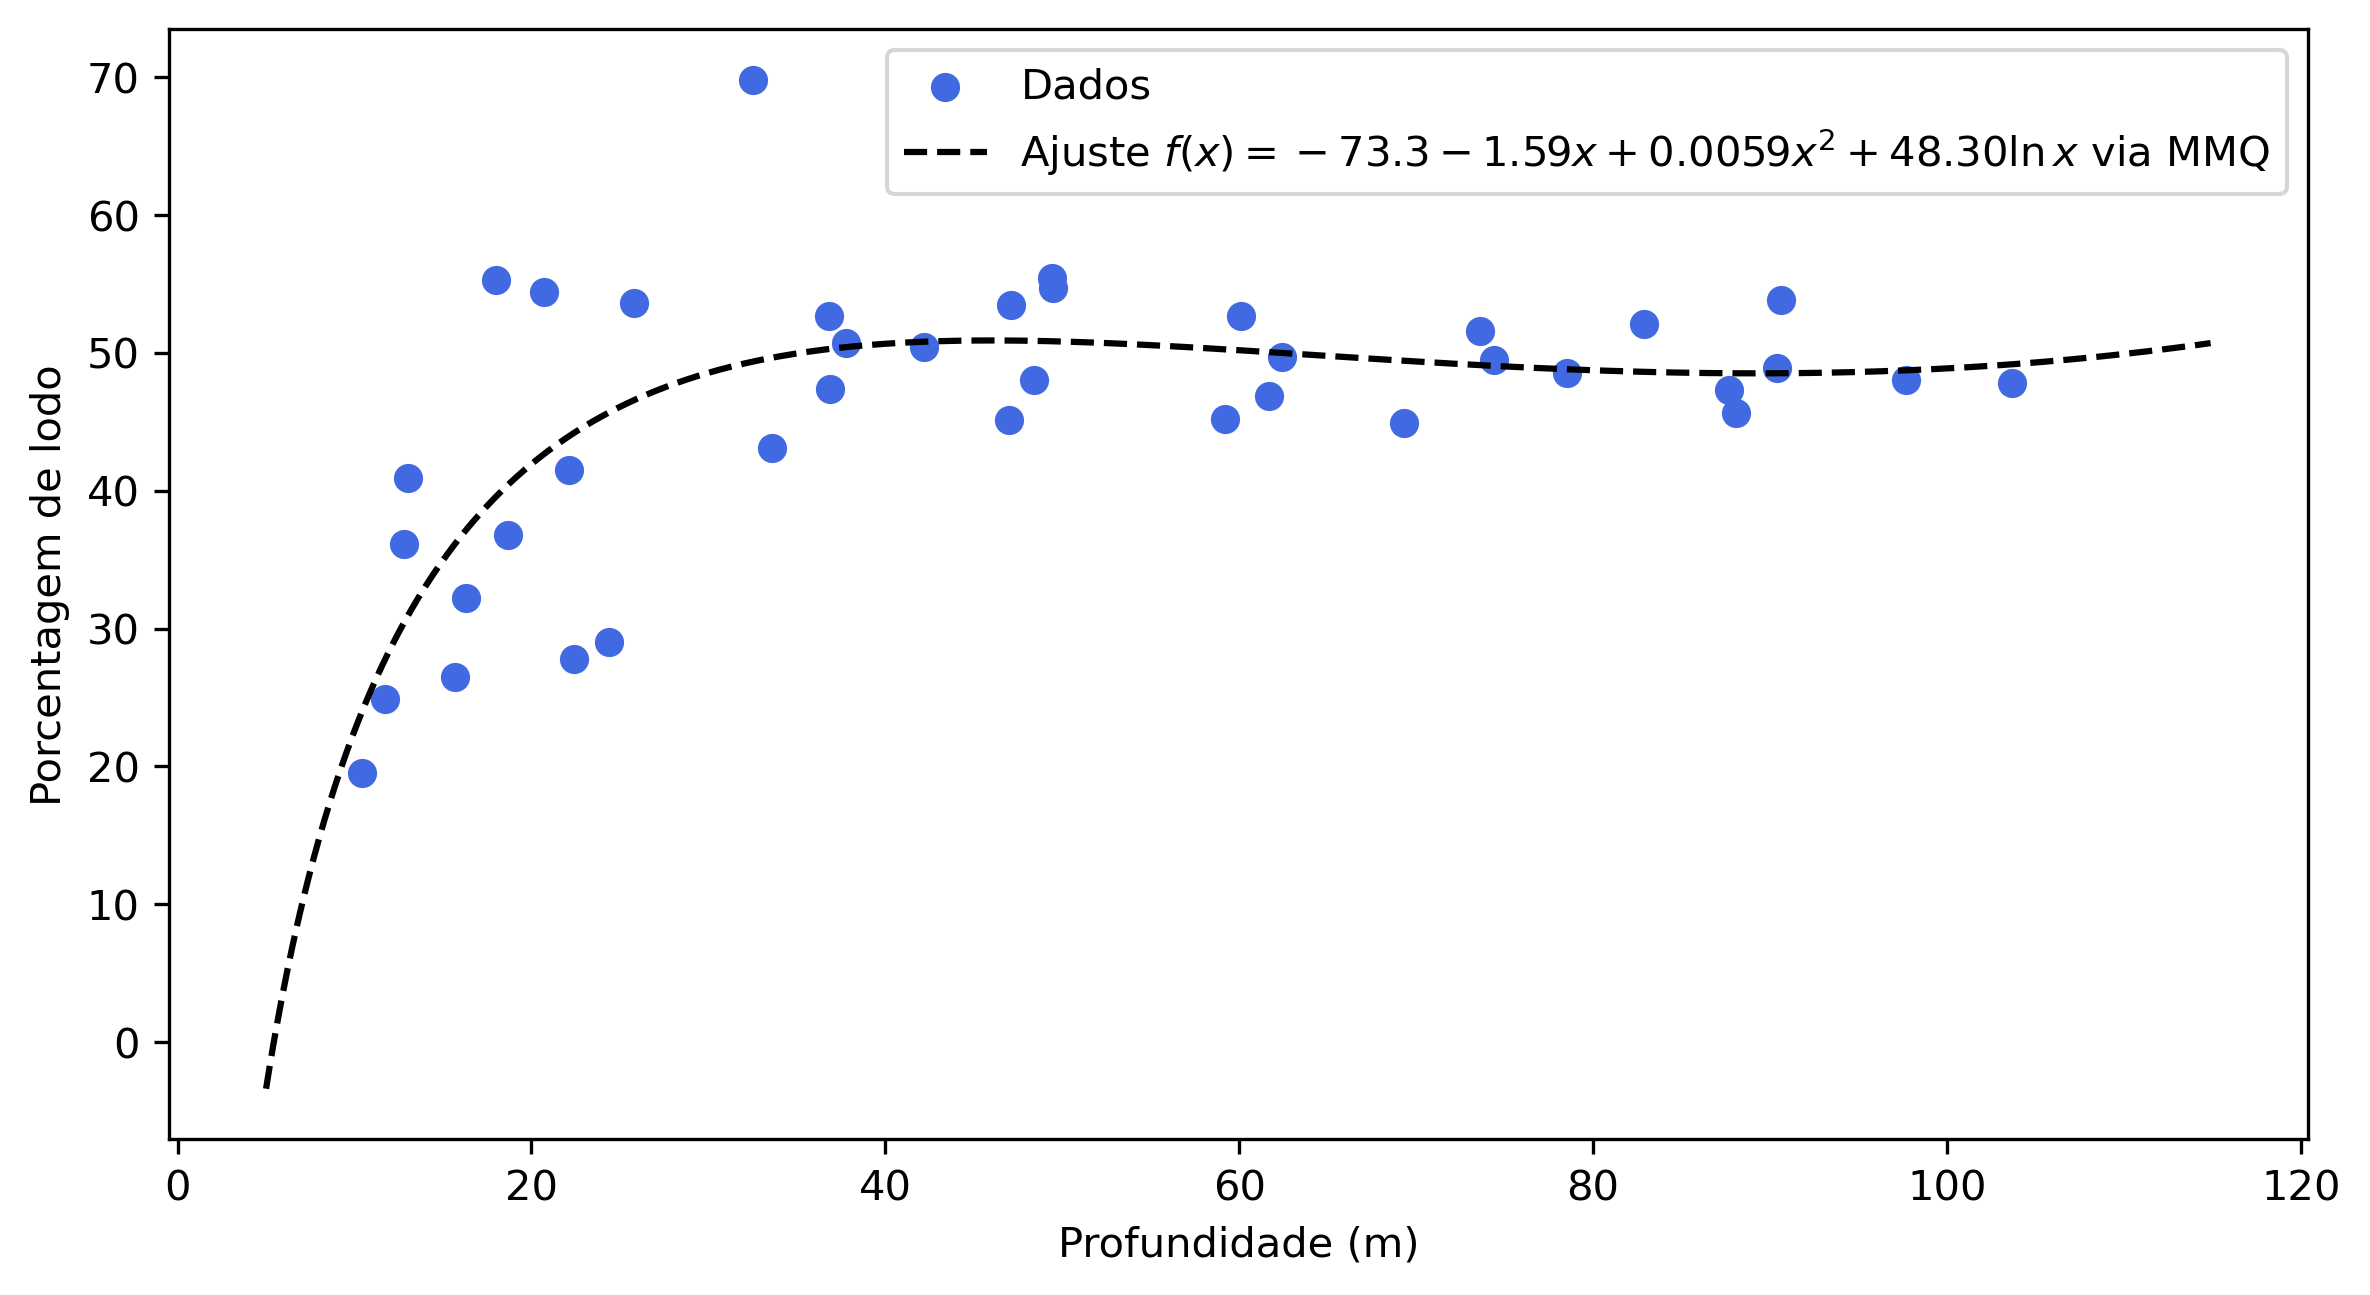

In [21]:
#Gerando o gráfico
plt.figure(figsize = [9.2,4.9], dpi = 300)
plt.scatter(x,y, color = 'royalblue', label = 'Dados')
x_cont = np.arange(5,115,0.1)
plt.plot(x_cont,f(x_cont,alpha,cte_1,x_func,x_square,log), ls = '--', color = 'black', label =  r'Ajuste $f(x)=-73.3-1.59x+0.0059x^2 + 48.30\ln{x}$ via MMQ')
plt.xlabel('Profundidade (m)')
plt.ylabel('Porcentagem de lodo')
plt.legend()
plt.savefig('Grafico_Ex1.pdf', dpi = 300)
plt.show()

In [22]:
#Escrevendo a tabela em um arquivo .txt
z = open("lista_2_output.txt", "w")
print('Primeiro exercício', file = z)
print('Tabela contendo os coeficientes ajustados via método de mínimos quadrados:', file = z)
print(tabulate([np.append(['alpha_i'],alpha)],headers = np.append(['i'],index),tablefmt='grid',numalign="center", floatfmt = ".17f"), file = z)
print(file = z)
z.close()

## Verificação pela biblioteca scipy:

In [23]:
def func_scp(x,a,b,c,d):
    return a + b*x + c*(x**2) + d*np.log(x)

In [24]:
fit_param, cov_param = curve_fit(func_scp,x,y)
print(fit_param)

[-7.33026875e+01 -1.59064644e+00  5.88032637e-03  4.83001121e+01]


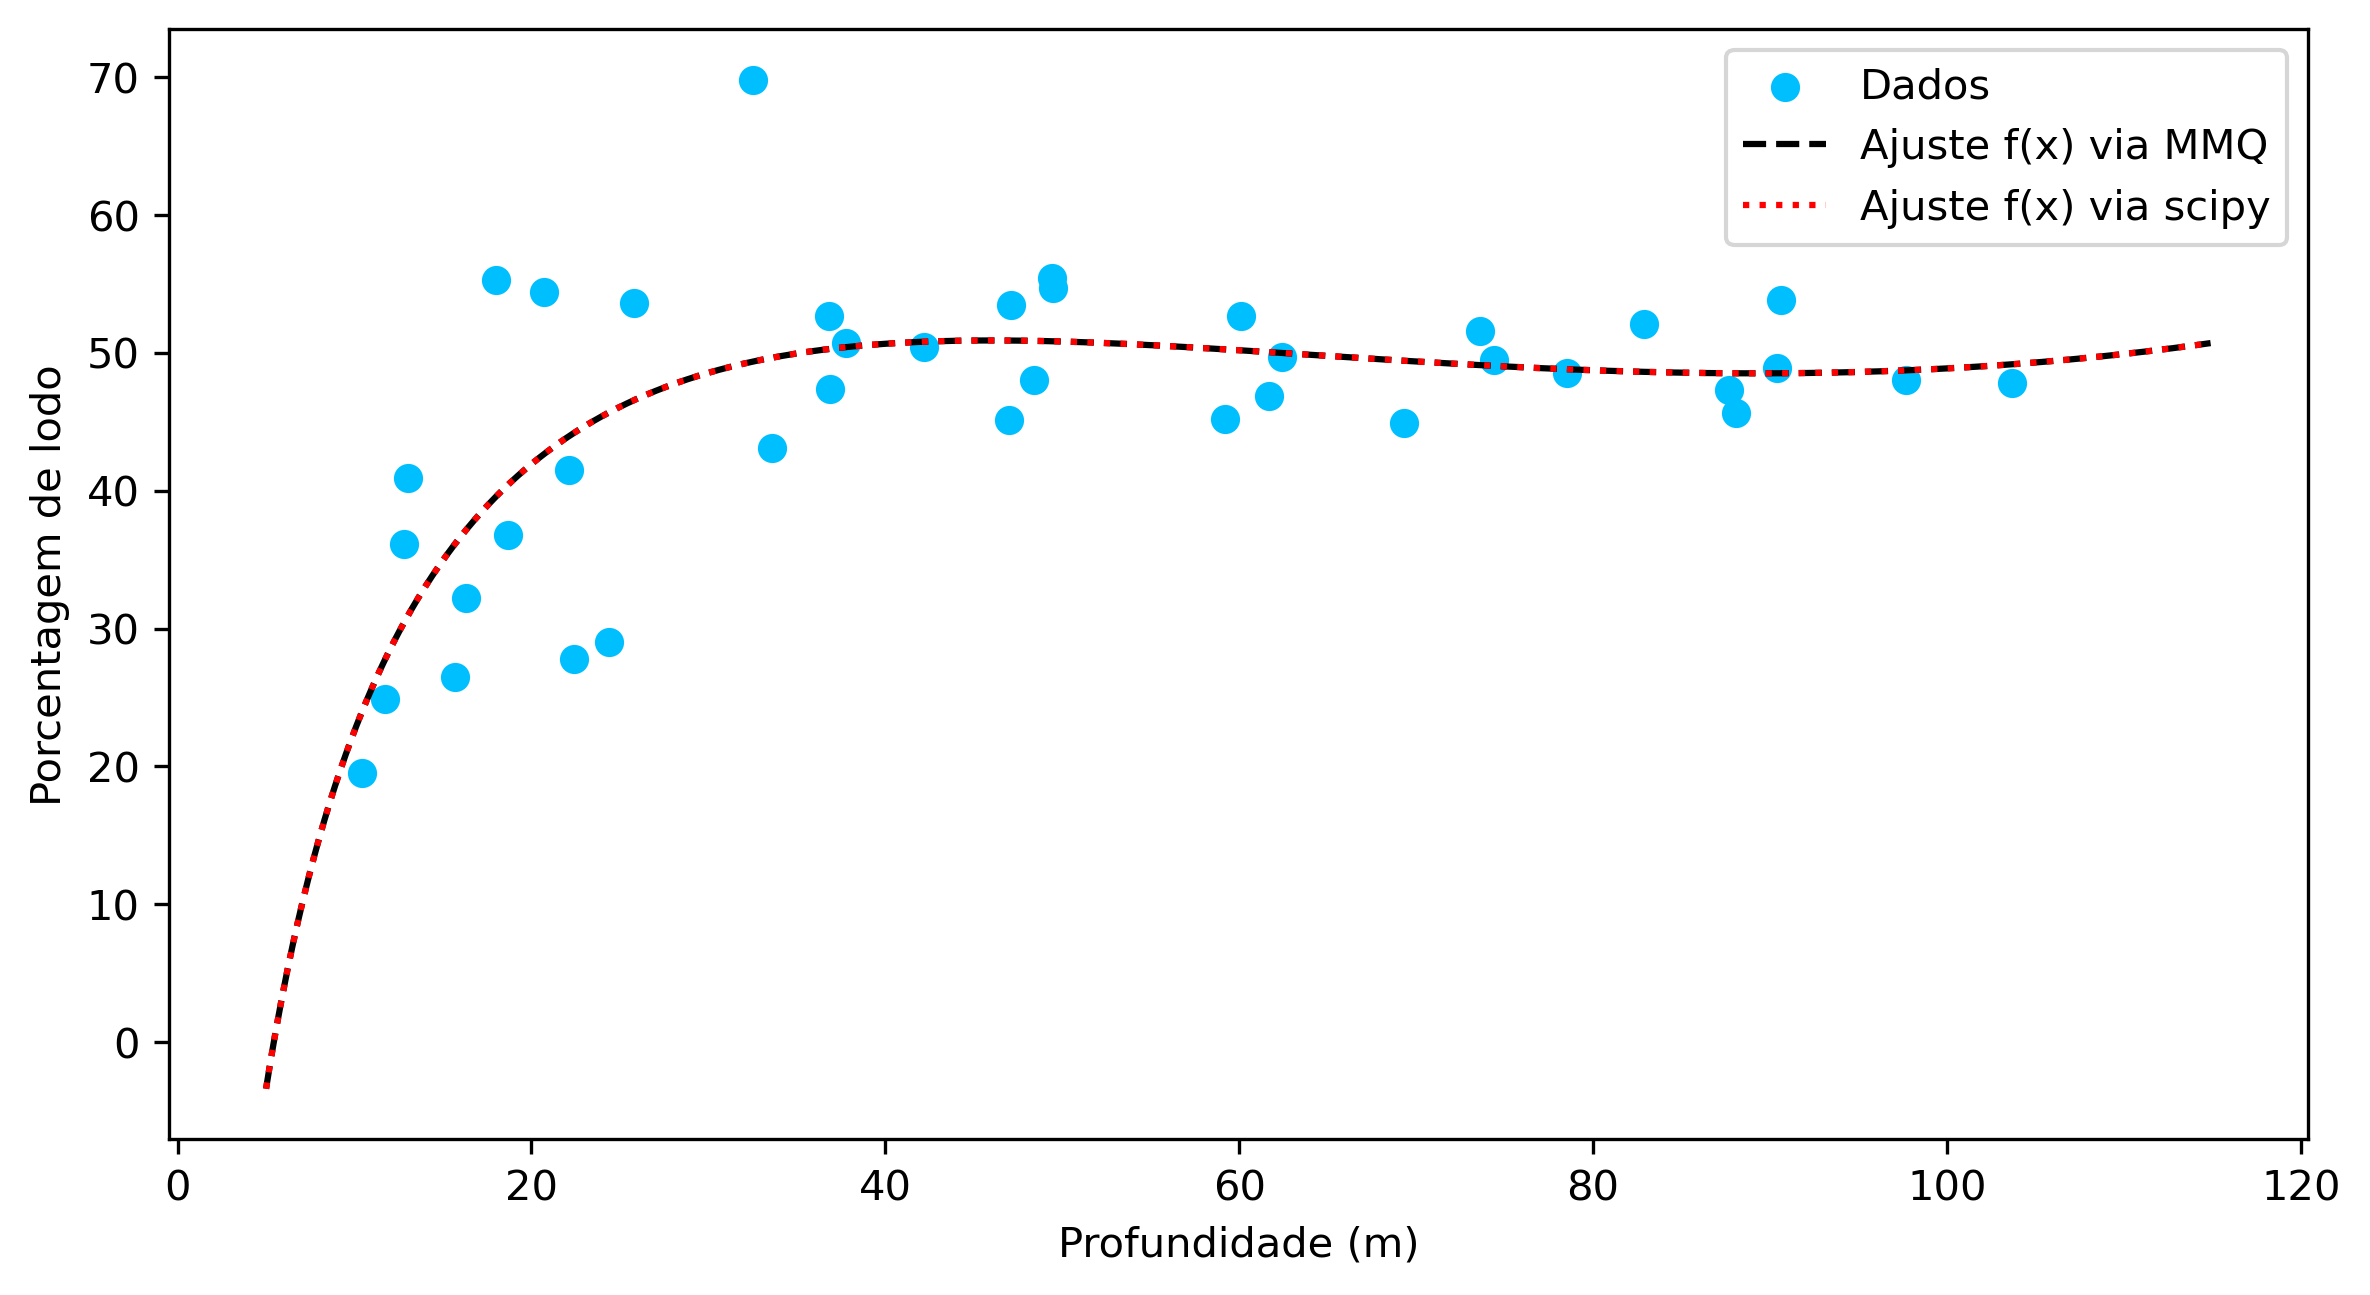

In [25]:
#Gerando o gráfico
plt.figure(figsize = [9.2,4.9], dpi = 300)
plt.scatter(x,y, color = 'deepskyblue', label = 'Dados')
x_cont = np.arange(5,115,0.1)
plt.plot(x_cont,f(x_cont,alpha,cte_1,x_func,x_square,log), ls = '--', color = 'black', label =  "Ajuste f(x) via MMQ")
plt.plot(x_cont,f(x_cont,fit_param,cte_1,x_func,x_square,log), ls = ':', color = 'red', label =  "Ajuste f(x) via scipy")
plt.xlabel('Profundidade (m)')
plt.ylabel('Porcentagem de lodo')
plt.legend()
plt.show()

# Segundo exercício

## Tarefa 1

### Item 1

Calculando a regra dos trapézios para $T(h_{s,k}),T(2h_{s,k}),...,T(2^k h_{s,k})$ com $f(x) = e^x$, $s=3$, $k=2$, $m=s2^k$, $a=0$, $b=1$


In [26]:
#Dados

a = 0
b = 1
s = 3
k = 2
m = s * (2**k)
h_0 = (b-a)/m

t_h = ['T(x*h)']
index = ['x']
for i in range(0,k+1):
    index.append(2 ** i) 
    t_h.append(trapezoidal_rule(a,b,int(m/(2**i)),exp))

In [27]:
#Imprimindo os resultados

print("Segundo exercício, Tarefa 1")
print("A tabela contendo os valores obtidos pela regra dos trapézios é:")
print(tabulate([t_h],headers = index,tablefmt='grid',numalign="center", floatfmt = ".17f"))
print()

print()

Segundo exercício, Tarefa 1
A tabela contendo os valores obtidos pela regra dos trapézios é:
+--------+---------------------+---------------------+---------------------+
| x      |          1          |          2          |          4          |
+========+=====================+=====================+=====================+
| T(x*h) | 1.71927608944638610 | 1.72225749247148130 | 1.73416246012342912 |
+--------+---------------------+---------------------+---------------------+




In [28]:
#Escrevendo esses resultados em um arquivo .txt
z = open("lista_2_output.txt", "a")
print("Segundo exercício, Tarefa 1, item 1", file = z)
print("A tabela contendo os valores obtidos pela regra dos trapézios é:", file = z)
print(tabulate([t_h],headers = index,tablefmt='grid',numalign="center", floatfmt = ".17f"), file  = z)
print(file = z)
z.close()

### Item 2
### Sub-item (a)

In [29]:
#Gerando os dados x_i = (2^i h)^2 e y_i = T(2^i h),
#onde T(h) é a integral calculada via método dos trapézios

x_i = [((idx*h_0)**2) for idx in index[1:]]
y_i = t_h[1:]


In [30]:
#Imprimindo o resultado do sub-item(a)

print(tabulate([np.append('x_i',x_i),np.append('y_i',y_i)],headers = np.append(['i'],[0,1,2]),tablefmt='grid',numalign="center", floatfmt = ".17f"))

+-----+---------------------+---------------------+---------------------+
| i   |          0          |          1          |          2          |
+=====+=====================+=====================+=====================+
| x_i | 0.00694444444444444 | 0.02777777777777778 | 0.11111111111111110 |
+-----+---------------------+---------------------+---------------------+
| y_i | 1.71927608944638610 | 1.72225749247148130 | 1.73416246012342912 |
+-----+---------------------+---------------------+---------------------+


In [31]:
#Escrevendo esses resultados em um arquivo .txt
z = open("lista_2_output.txt", "a")
print("Segundo exercício, Tarefa 1, item 2, sub-item (a)", file = z)
print(tabulate([np.append('x_i',x_i),np.append('y_i',y_i)],headers = np.append(['i'],[0,1,2]),tablefmt='grid',numalign="center", floatfmt = ".17f"), file = z)
z.close()

### Sub-item (b)

In [32]:
#Calculando a integral via romberg
int_romberg, poly_coefs  = romberg_integral(x_i,y_i, print_coef = True)

In [33]:
#Imprimindo o resultado
print('Tabela contendo os coeficientes do polinômio interpolador:')
print(tabulate([np.append('alpha_i',poly_coefs)],headers = np.append(['f_i(x)'],[1,'x','x^2']),tablefmt='grid',numalign="center", floatfmt = ".17f"))
print('A integral segundo o método de Romberg resulta em:',int_romberg)


Tabela contendo os coeficientes do polinômio interpolador:
+----------+---------------------+---------------------+----------------------+
| f_i(x)   |          1          |          x          |         x^2          |
+==========+=====================+=====================+======================+
| alpha_i  | 1.71927608944638610 | 0.14310734520456947 | -0.00237824045947832 |
+----------+---------------------+---------------------+----------------------+
A integral segundo o método de Romberg resulta em: 1.7182818296725004


In [34]:
#Escrevendo esses resultados em um arquivo .txt
z = open("lista_2_output.txt", "a")
print("Segundo exercício, Tarefa 1, item 2, sub-item (b)", file = z)
print('Tabela contendo os coeficientes do polinômio interpolador:', file = z)
print(tabulate([np.append('alpha_i',poly_coefs)],headers = np.append(['f_i(x)'],[1,'x','x^2']),tablefmt='grid',numalign="center", floatfmt = ".17f"), file = z)
print('A integral segundo o método de Romberg resulta em:',int_romberg, file = z)
print(file = z)
z.close()

### Item 3

In [57]:
#Calculando o erro no método dos trapézios:

erro_T = abs(t_h[1] - np.e + 1)

#Calculando o erro pelo método de Romberg:

erro_R = abs(romberg_integral(x_i,y_i) - np.e + 1 )


In [36]:
#Output do item 3
print('Segundo exercício, Tarefa 1, Item 3')
print('O erro do método de Trapézios é: %.17f' % erro_T)
print('O erro do método de Romberg é: %.17f' % erro_R)
print('Logo, o erro atrelado ao método de Romberg é menor.')
print()

Segundo exercício, Tarefa 1, Item 3
O erro do método de Trapézios é: 0.00099426098734101
O erro do método de Romberg é: 0.00000000121345534
Logo, o erro atrelado ao método de Romberg é menor.



In [37]:
#Escrevendo esses resultados em um arquivo .txt
z = open("lista_2_output.txt", "a")
print('Segundo exercício, Tarefa 1, Item 3', file = z)
print('O erro do método de Trapézios é: %.17f' % erro_T, file = z)
print('O erro do método de Romberg é: %.17f' % erro_R, file = z)
print('Logo, o erro atrelado ao método de Romberg é menor.', file = z)
print(file = z)
z.close()

## Tarefa 2
### Item 1

In [38]:
h_2 = ['h']
t_error = ['E_T']
r_error = ['E_R']
for s in range(3,11):
    #Dados
    a = 0
    b = 1
    k = 2
    m = s * (2**k)
    h_0 = (b-a)/m
    h_2.append(h_0)
    
    #Calculando a regra dos trapézios para h até 2^k h
    tr = []
    idx = []
    for i in range(0,k+1):
        idx.append(2 ** i) 
        tr.append(trapezoidal_rule(a,b,int(m/(2**i)),exp))
    
    #Canculando o vetor de x_i que será utilizado para interpolação
    x_2 = [((i*h_0)**2) for i in idx]
    
    #Calculando a integral pelo método de Romberg
    r_int = romberg_integral(x_2,tr)
    
    #Erro associado a integral de Romberg
    r_error.append(abs(r_int - np.e + 1 ))
    
    #Erro associado a regra dos trapézios
    t_error.append(abs(tr[0] - np.e + 1))

In [39]:
print('Segundo exercício, Tarefa 2, Item 1')
print(tabulate([t_error,r_error],headers = np.append(['s'],np.arange(3,11,1)),tablefmt='grid',numalign="center", floatfmt = ".17f"))
print()

Segundo exercício, Tarefa 2, Item 1
+-----+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
| s   |          3          |          4          |          5          |          6          |          7          |          8          |          9          |         10          |
+=====+=====================+=====================+=====================+=====================+=====================+=====================+=====================+=====================+
| E_T | 0.00099426098734101 | 0.00055930012094962 | 0.00035796046617631 | 0.00024858682171747 | 0.00018263661792828 | 0.00013983185728184 | 0.00011048480784592 | 0.00008949291301907 |
+-----+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
| E_R | 0.00000000121345534 | 0.000000000216

In [40]:
#Escrevendo esses resultados em um arquivo .txt
z = open("lista_2_output.txt", "a")
print('Segundo exercício, Tarefa 2, Item 1', file  = z)
print(tabulate([t_error,r_error], np.append(['s'],np.arange(3,11,1)),tablefmt='grid',numalign="center", floatfmt = ".17f"), file = z)
print(file = z)
z.close()

### Item 2 e 3

In [41]:
#Calculando o log10 das grandezas envolvidas
log_h = np.log(h_2[1:])
log_E_T = np.log(t_error[1:])
log_E_R = np.log(r_error[1:])

funcs2 = [cte_1,x_func]

#Calculando o ajuste para o método dos trapézios
coef_matT = coef_matrix(log_h,2,funcs2)
equal_vecT = equal_vector(log_h,log_E_T,2,funcs2)
alphaT = eliminacaoGauss(coef_matT, equal_vecT, 2)

#Calculando o ajuste para o método de Romberg
coef_matR = coef_matrix(log_h,2,funcs2)
equal_vecR = equal_vector(log_h,log_E_R,2,funcs2)
alphaR = eliminacaoGauss(coef_matR, equal_vecR, 2)



In [42]:
#Imprimindo os reusltados
print('Segundo exercício, Tarefa 2, Item 2')
print('Os coeficientes dos ajustes para ln(x) = alpha_1 + alpha_2 ln(h), obtidos via MMQ são:')
print(tabulate([np.append(['Trapezios'],alphaT),np.append(['Romberg'],alphaR)],headers = ['Método', 'alpha_1', 'alpha_2'],tablefmt='grid',numalign="center", floatfmt = ".17f"))


Segundo exercício, Tarefa 2, Item 2
Os coeficientes dos ajustes para ln(x) = alpha_1 + alpha_2 ln(h), obtidos via MMQ são:
+-----------+----------------------+---------------------+
| Método    |       alpha_1        |       alpha_2       |
+===========+======================+=====================+
| Trapezios | -1.94388108632342149 | 1.99991835456728606 |
+-----------+----------------------+---------------------+
| Romberg   | -5.62688654369184249 | 5.99717194873121784 |
+-----------+----------------------+---------------------+


In [43]:
#Escrevendo esses resultados em um arquivo .txt
z = open("lista_2_output.txt", "a")
print('Segundo exercício, Tarefa 2, Item 2', file  = z)
print('Os coeficientes dos ajustes para ln(x) = \alpha_1 + alpha_2 ln(h), obtidos via MMQ são:', file = z)
print(tabulate([np.append(['Trapezios'],alphaT),np.append(['Romberg'],alphaR)],headers = ['Método', 'alpha_1', 'alpha_2'],tablefmt='grid',numalign="center", floatfmt = ".17f"), file = z)
print(file = z)
z.close()



In [44]:
print(log_h)

[-2.48490665 -2.77258872 -2.99573227 -3.17805383 -3.33220451 -3.4657359
 -3.58351894 -3.68887945]


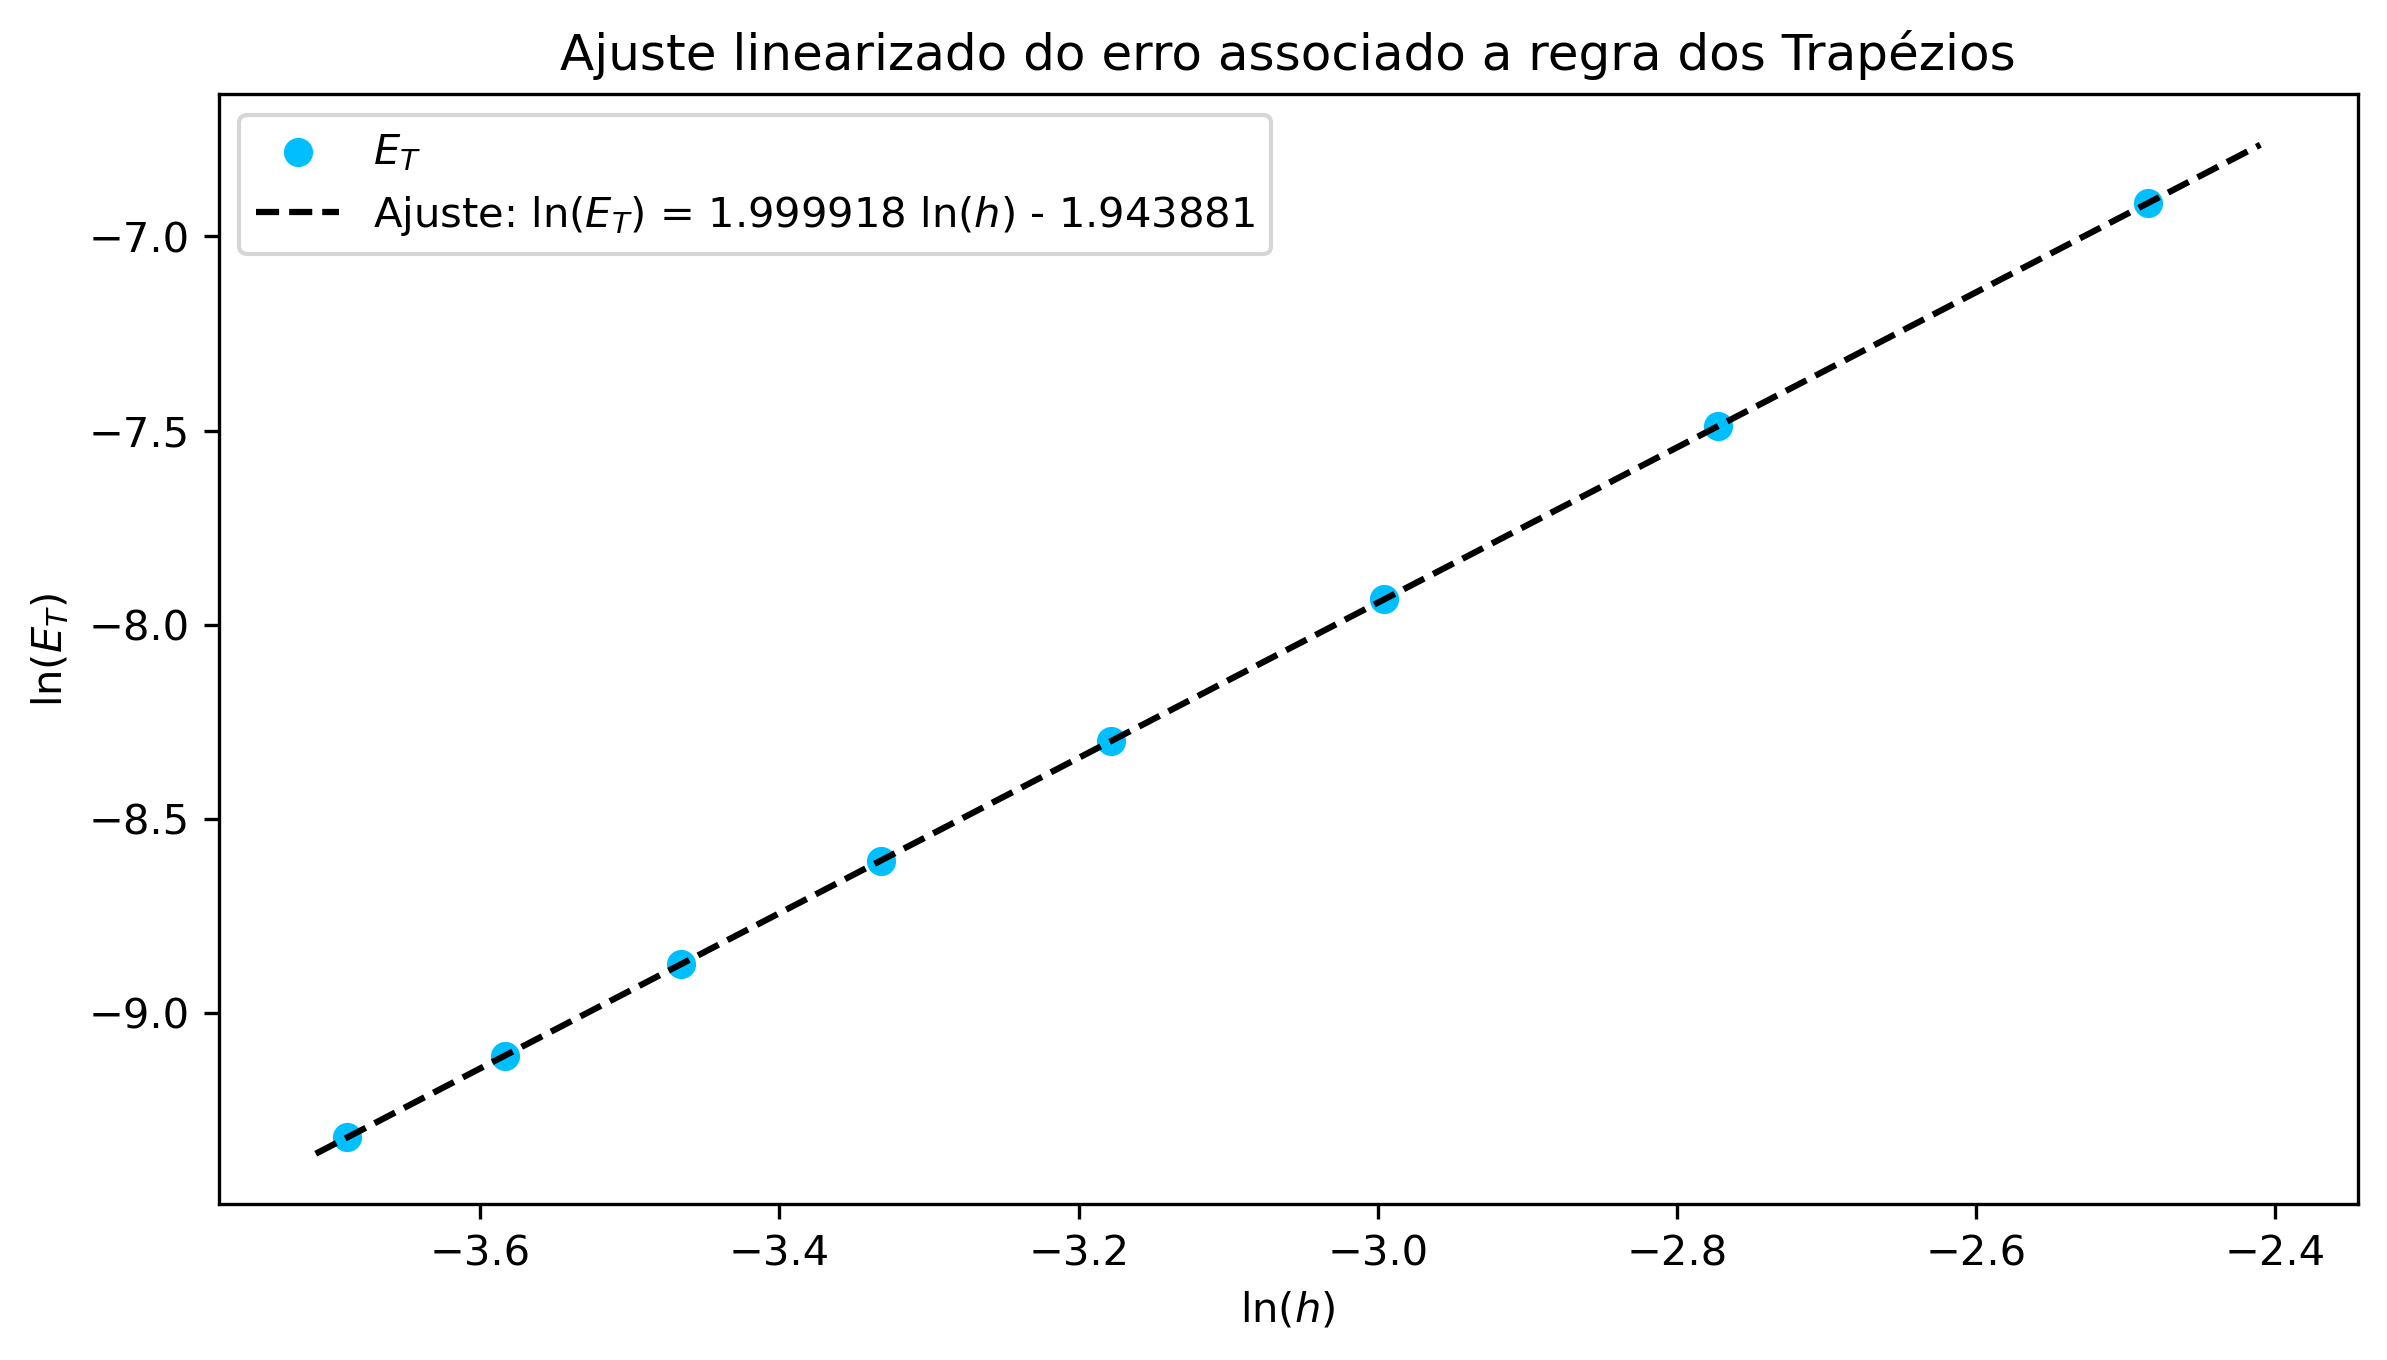

In [45]:
plt.figure(figsize = [9.2,4.9], dpi = 300)
plt.scatter(log_h,log_E_T, color = 'deepskyblue', label = r'$E_T$')
x_cont = np.arange(-3.71,-2.4,0.01)
plt.plot(x_cont,f(x_cont,alphaT,cte_1,x_func), ls = '--', color = 'black', label =  "Ajuste: $\ln(E_T)$ = %.6f $\ln(h)$ - %.6f" % (alphaT[1],abs(alphaT[0])))
plt.xlabel(r'$\ln(h)$')
plt.ylabel(r'$\ln(E_T)$')
plt.title('Ajuste linearizado do erro associado a regra dos Trapézios')
plt.legend()
plt.savefig('Grafico_Tarefa2_Trapezios.pdf',dpi = 300)
plt.show()

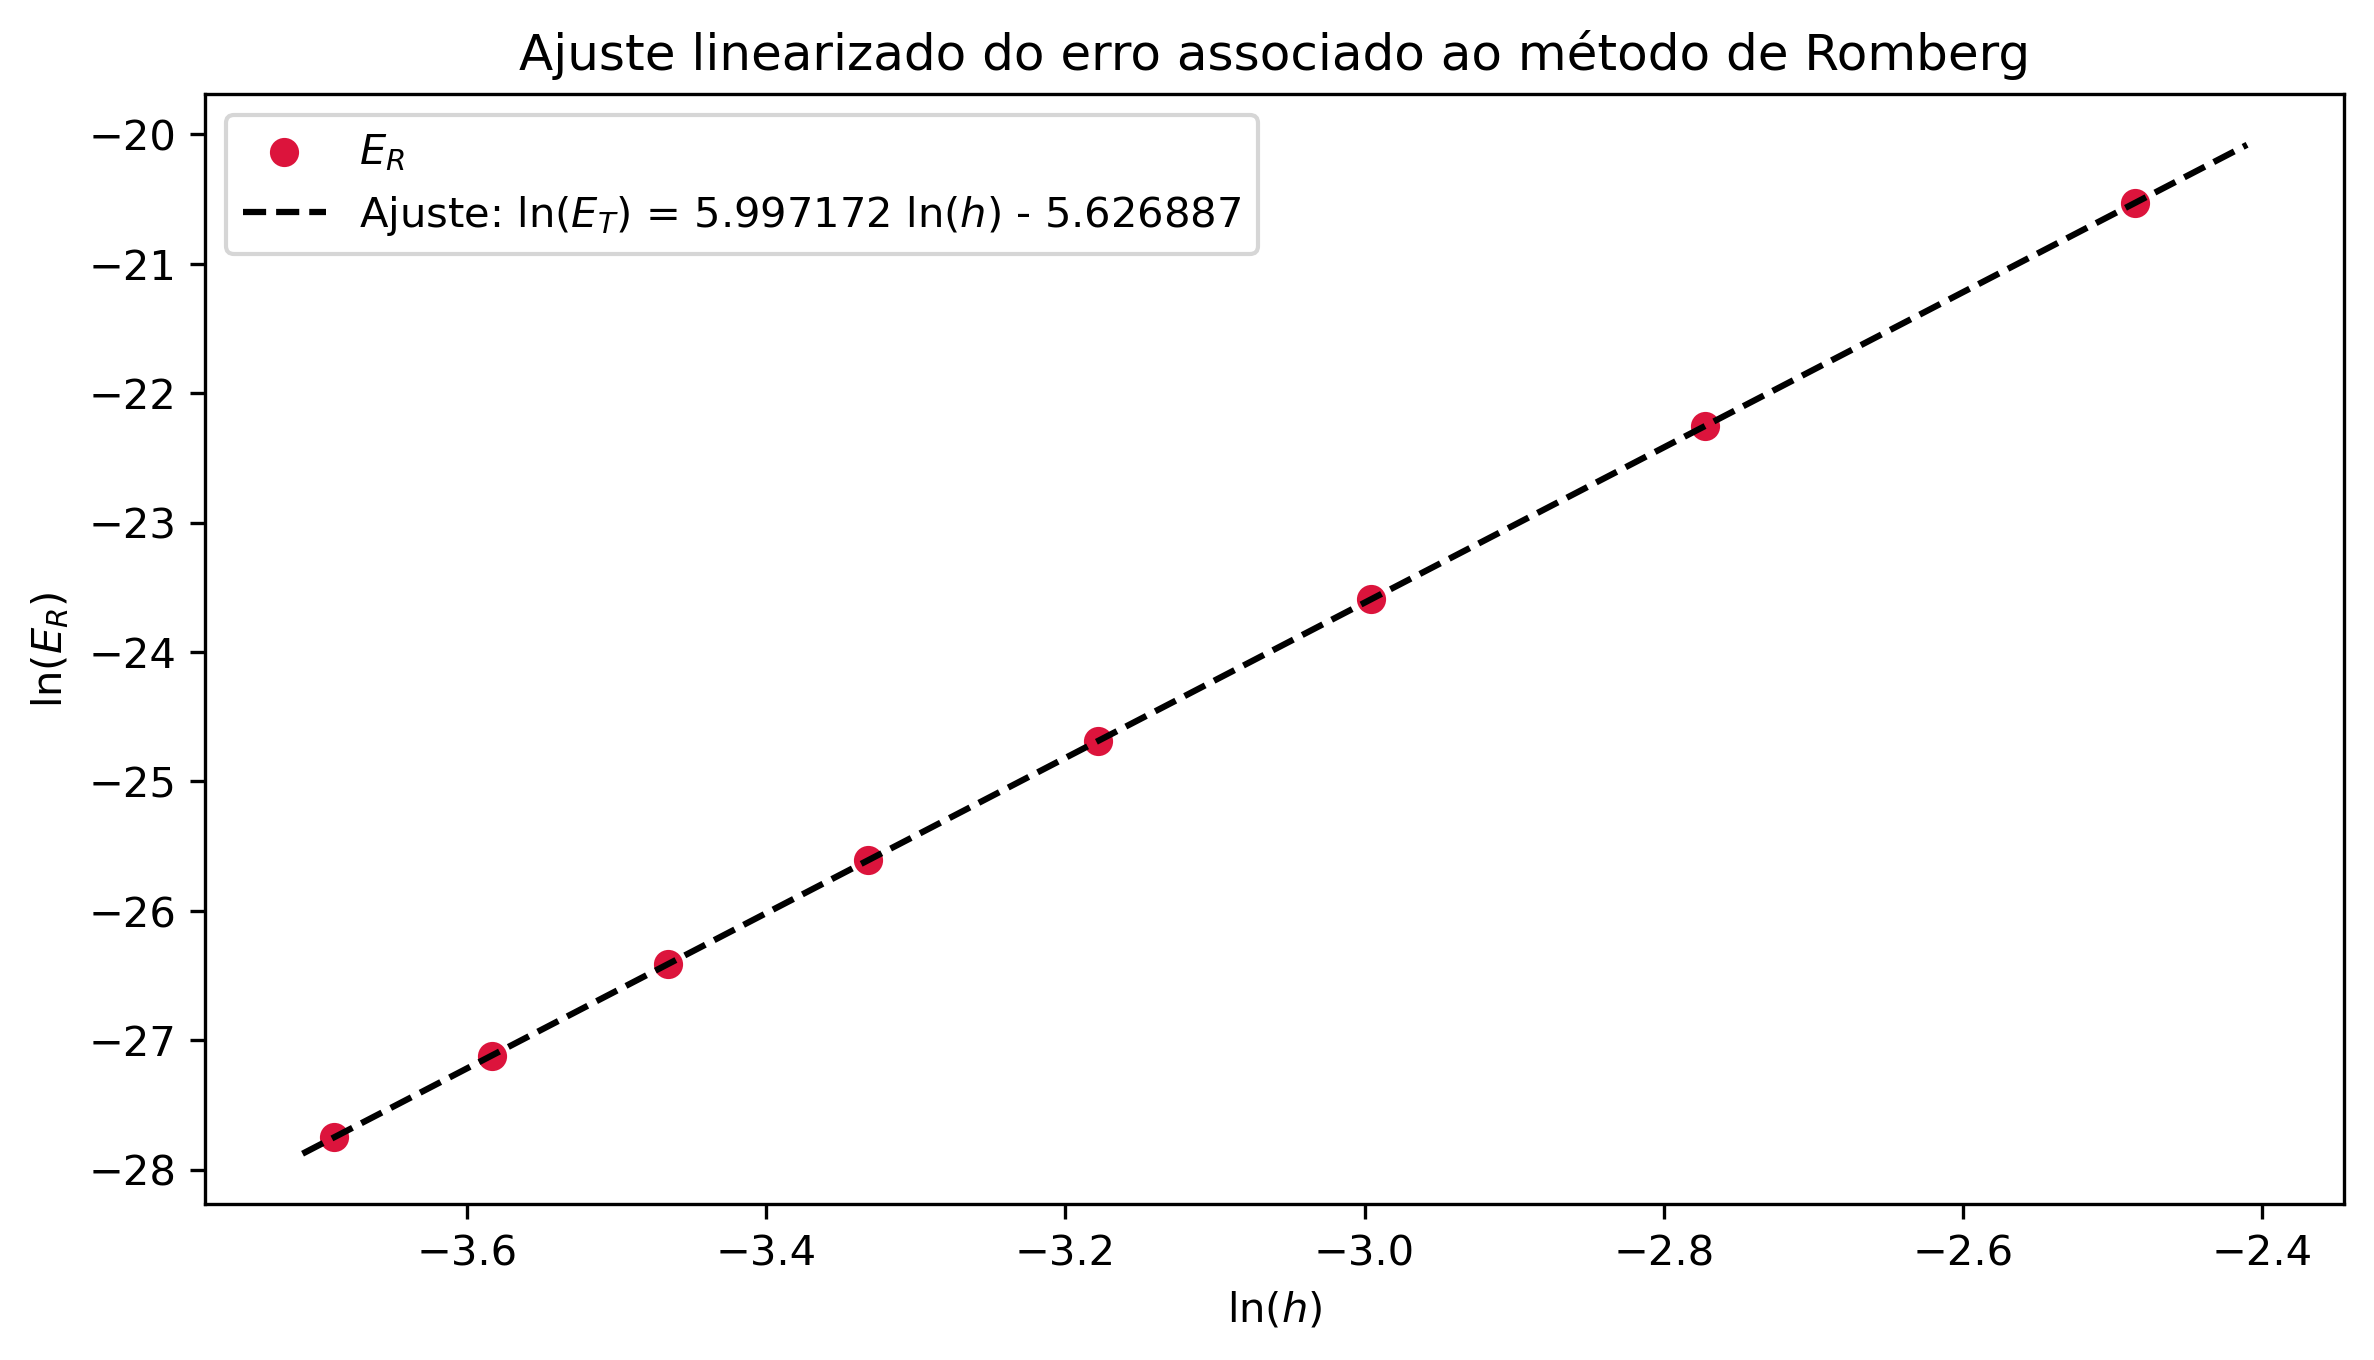

In [46]:
plt.figure(figsize = [9.2,4.9], dpi = 300)
plt.scatter(log_h,log_E_R, color = 'crimson', label = r'$E_R$')
x_cont = np.arange(-3.71,-2.4,0.01)
plt.plot(x_cont,f(x_cont,alphaR,cte_1,x_func), ls = '--', color = 'black', label =  "Ajuste: $\ln(E_T)$ = %.6f $\ln(h)$ - %.6f" % (alphaR[1],abs(alphaR[0])))
plt.xlabel(r'$\ln(h)$')
plt.ylabel(r'$\ln(E_R)$')
plt.title('Ajuste linearizado do erro associado ao método de Romberg')
plt.legend()
plt.savefig('Grafico_Tarefa2_Romberg.pdf',dpi = 300)
plt.show()

## Tarefa 3
### Item 1

In [47]:
print(np.e-1)
print(simpson_integral(0,1,12,exp))

1.718281828459045
1.7182822884380207


In [48]:
#Dados

a = 0
b = 1
k = 1


r_error3 = ['E_R']
s_error = ['E_S']
for s in range(3,11):

    m = s * (2**k)
    h_0 = (b-a)/m

    trap = []
    idx3 = []
    for i in range(0,k+1):
        idx3.append(2 ** i) 
        trap.append(trapezoidal_rule(a,b,int(m/(2**i)),exp))
        
    #Canculando o vetor de x_i que será utilizado para interpolação
    x_3 = [((i*h_0)**2) for i in idx3]
    
    #Calculando a integral pelo método de Romberg
    r_int3 = romberg_integral(x_3,trap)
    
    #Erro associado a integral de Romberg
    r_error3.append(abs(r_int3 - np.e + 1 ))
    
    #Erro associado a regra dos trapézios
    s_error.append(abs(simpson_integral(a,b,m,exp) - np.e + 1))

In [49]:
print('Segundo exercício, Tarefa 3, Item 1')
print(tabulate([s_error,r_error3],headers = np.append(['s'],np.arange(3,11,1)),tablefmt='grid',numalign="center", floatfmt = ".17f"))
print()

Segundo exercício, Tarefa 3, Item 1
+-----+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
| s   |          3          |          4          |          5          |          6          |          7          |          8          |          9          |         10          |
+=====+=====================+=====================+=====================+=====================+=====================+=====================+=====================+=====================+
| E_S | 0.00000734146178649 | 0.00000232624085195 | 0.00000095346577855 | 0.00000045997897558 | 0.00000024833962775 | 0.00000014559284667 | 0.00000009090176589 | 0.00000005964481198 |
+-----+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
| E_R | 0.00000734146178694 | 0.000002326240

In [50]:
#Escrevendo esses resultados em um arquivo .txt
z = open("lista_2_output.txt", "a")
print('Segundo exercício, Tarefa 3, Item 1', file  = z)
print(tabulate([s_error,r_error3],headers = np.append(['s'],np.arange(3,11,1)),tablefmt='grid',numalign="center", floatfmt = ".17f"), file = z)
print(file = z)
z.close()

## Tarefa 4

In [51]:
frac_error_x20 = []
frac_error_x_log = []
for k in range(1,7):
    a=0
    b=1
    s=3
    m = s*(2**k)


    h_0 = (b-a)/m

    #Calculando a regra dos trapézios para h até 2^k h
    tr_x20 = []
    tr_x_log = []
    idx4 = []
    for i in range(0,k+1):
        idx4.append(2 ** i)
        tr_x_log.append(trapezoidal_rule(a,b,int(m/(2**i)),x_sqrtlog))
        tr_x20.append(trapezoidal_rule(a,b,int(m/(2**i)),x_powerof20))

    #Canculando o vetor de x_i que será utilizado para interpolação
    x_4 = [((i*h_0)**2) for i in idx4]

    #Calculando a integral pelo método de Romberg
    r_int_x20 = romberg_integral(x_4,tr_x20)
    r_error_x20 = abs(r_int_x20 - 1/21 )
    
    #
    r_int_x_log = romberg_integral(x_4,tr_x_log)
    r_error_x_log = abs(r_int_x_log + 4/9)


    t_error_x20 = abs(tr_x20[0] - 1/21)
    t_error_x_log = abs(tr_x_log[0] + 4/9)

    
    
    frac_error_x20.append(r_error_x20/t_error_x20)
    frac_error_x_log.append(r_error_x_log/t_error_x_log)




In [52]:
print('Segundo exercício, Tarefa 4, Item 1')
print('A tabela contendo a razão E_R/E_T para a integral da função f_1(x) = x^20, com k variando de 1 até 6, é:')
print(tabulate([np.append(['E_R/E_T'],frac_error_x20)],headers = np.append(['k'],np.arange(1,7,1)),tablefmt='grid',numalign="center", floatfmt = ".17f"))
print()
print('A tabela contendo a razão E_R/E_T para a integral da função f_1(x) = \sqrt{x}\ln(x), com k variando de 1 até 6, é:')
print(tabulate([np.append(['E_R/E_T'],frac_error_x_log)],headers = np.append(['k'],np.arange(1,7,1)),tablefmt='grid',numalign="center", floatfmt = ".17f"))
print()

Segundo exercício, Tarefa 4, Item 1
A tabela contendo a razão E_R/E_T para a integral da função f_1(x) = x^20, com k variando de 1 até 6, é:
+---------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
| k       |          1          |          2          |          3          |          4          |          5          |          6          |
+=========+=====================+=====================+=====================+=====================+=====================+=====================+
| E_R/E_T | 0.34320457543331095 | 0.05907136754579999 | 0.00241328127721186 | 0.00001899151076663 | 0.00000002617779300 | 0.00000000000506553 |
+---------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+

A tabela contendo a razão E_R/E_T para a integral da função f_1(x) = \sqrt{x}\ln(x), com k variando de 1 até 6, é:
+---------+------------

In [53]:
#Escrevendo esses resultados em um arquivo .txt
z = open("lista_2_output.txt", "a")
print('Segundo exercício, Tarefa 4, Item 1', file  = z)
print('A tabela contendo a razão E_R/E_T para a integral da função f_1(x) = x^20, com k variando de 1 até 6, é:', file  = z)
print(tabulate([np.append(['E_R/E_T'],frac_error_x20)],headers = np.append(['k'],np.arange(1,7,1)),tablefmt='grid',numalign="center", floatfmt = ".17f"), file  = z)
print(file = z)
print('A tabela contendo a razão E_R/E_T para a integral da função f_1(x) = \sqrt{x}\ln(x), com k variando de 1 até 6, é:', file  = z)
print(tabulate([np.append(['E_R/E_T'],frac_error_x_log)],headers = np.append(['k'],np.arange(1,7,1)),tablefmt='grid',numalign="center", floatfmt = ".17f"), file  = z)
print(file = z)
z.close()

C:\Users\Vinic\AppData\Local\Temp\ipykernel_15500\3074663826.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(k,frac_error_x20, 'o-', ls = '--',color = 'limegreen', label = r'Integração de $f_1(x) = x^{20}$')
C:\Users\Vinic\AppData\Local\Temp\ipykernel_15500\3074663826.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(k,frac_error_x_log, 'o-', ls = '--' ,color = 'indigo', label = r'Integração de $f_2(x) = \sqrt{x}\ln{x}$')


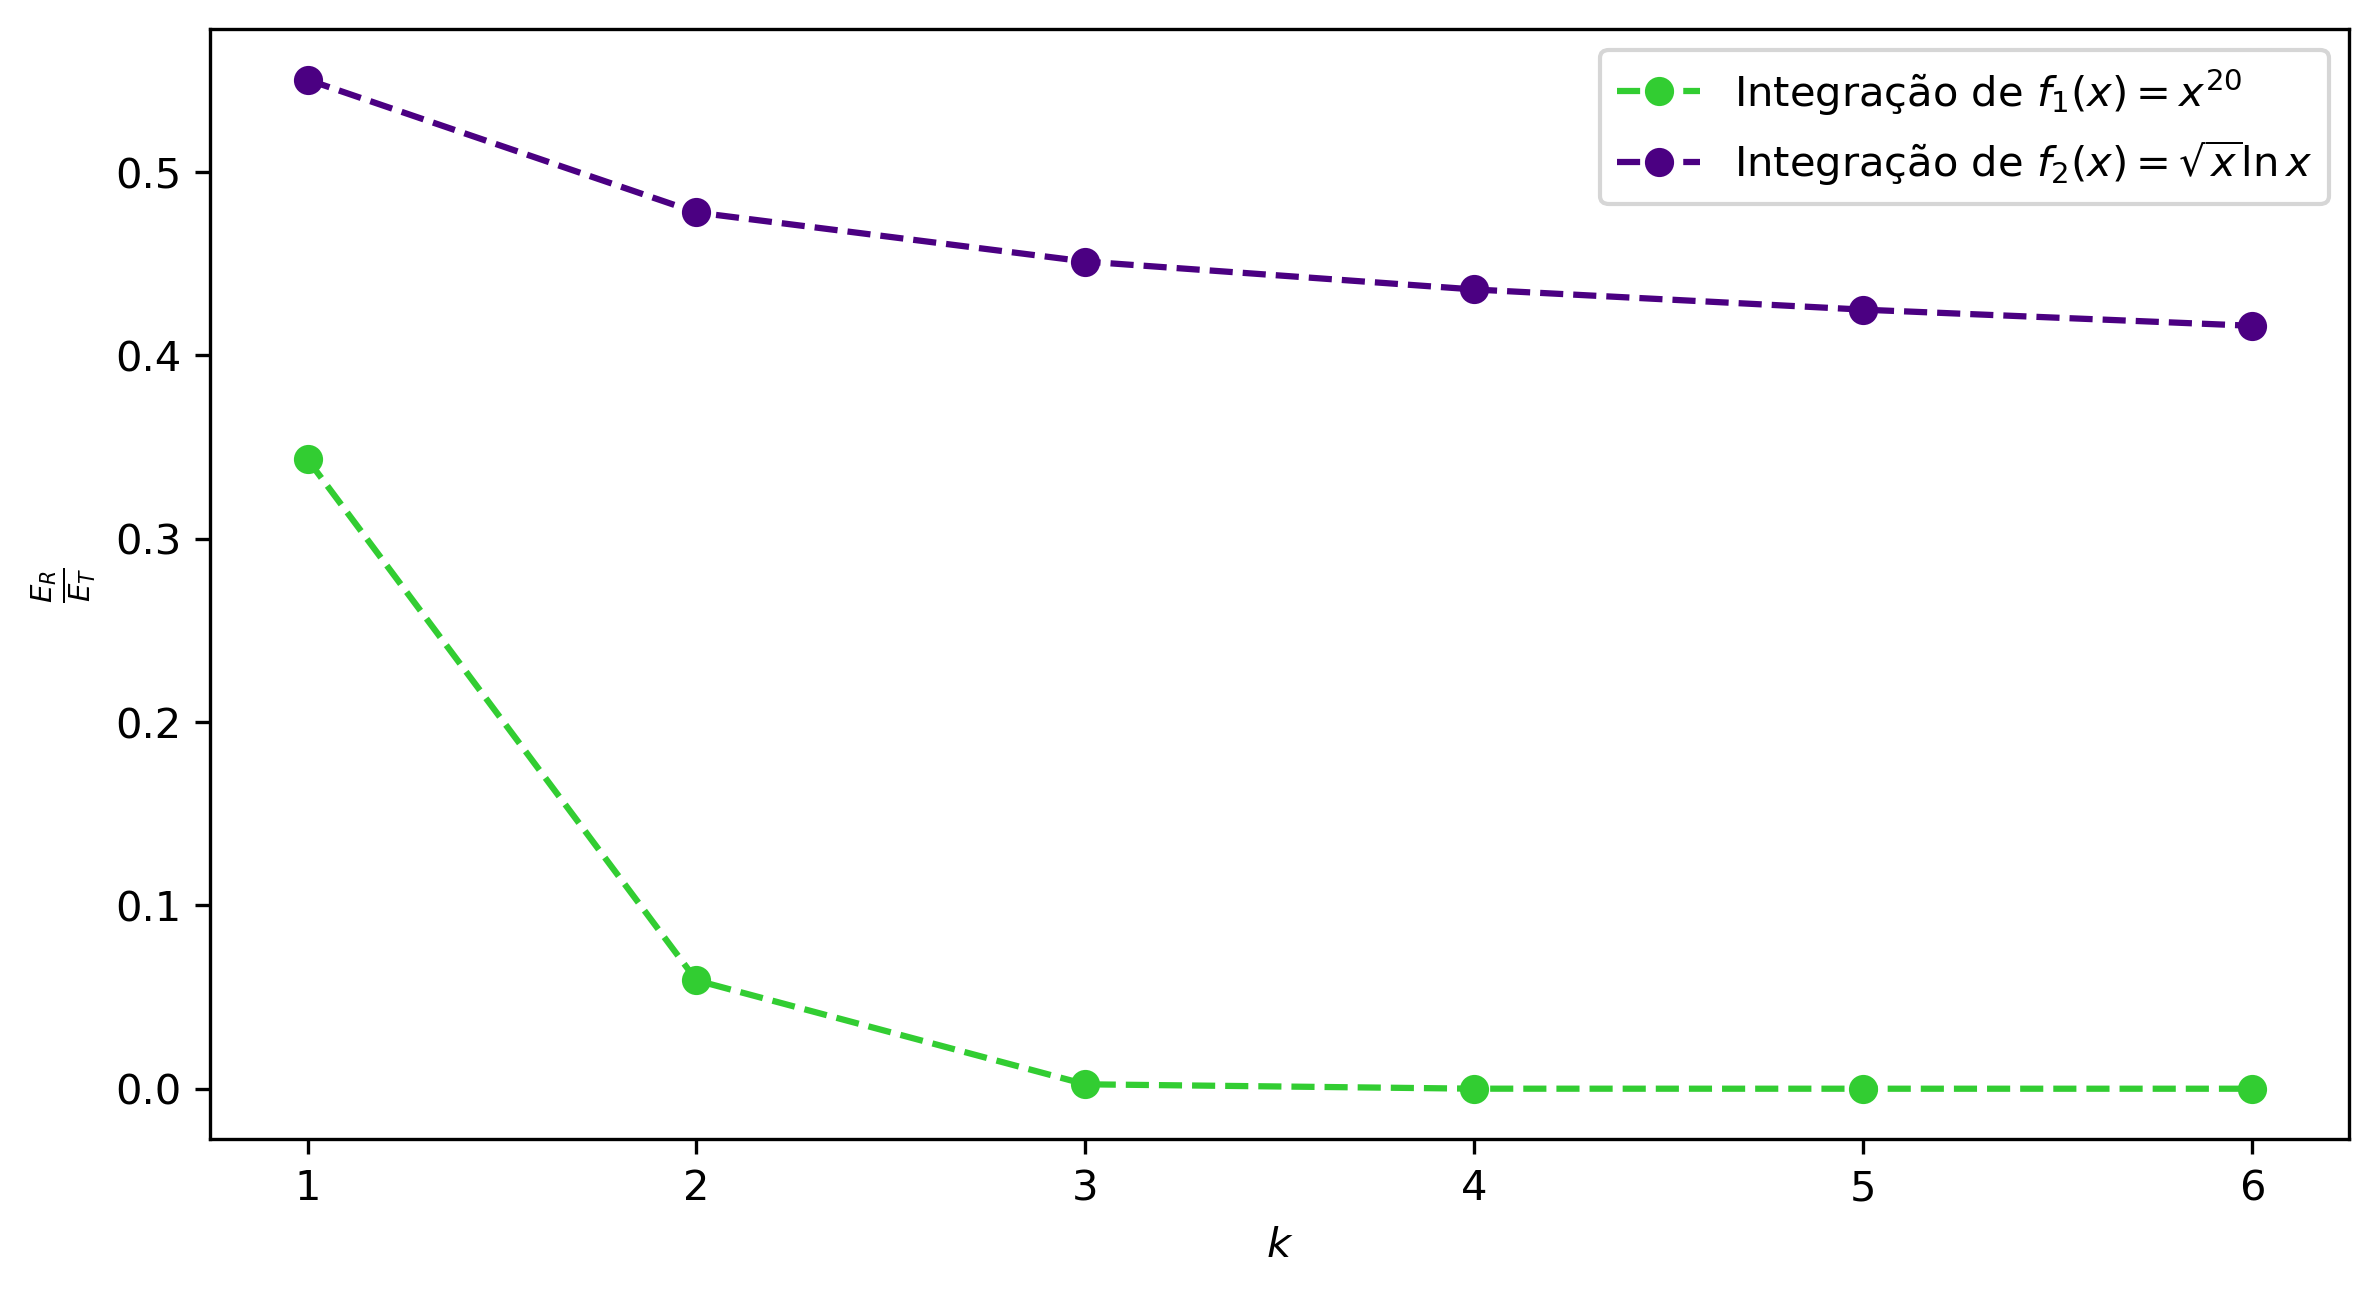

In [54]:
k = np.arange(1,7,1)

plt.figure(figsize = [9.2,4.9], dpi = 300)
plt.plot(k,frac_error_x20, 'o-', ls = '--',color = 'limegreen', label = r'Integração de $f_1(x) = x^{20}$')
plt.plot(k,frac_error_x_log, 'o-', ls = '--' ,color = 'indigo', label = r'Integração de $f_2(x) = \sqrt{x}\ln{x}$')

#plt.plot(x_cont,f(x_cont,alphaR,cte_1,x_func), ls = '--', color = 'black', label =  "Ajuste: $\ln(E_T)$ = %.6f $\ln(h)$ - %.6f" % (alphaR[1],abs(alphaR[0])))
plt.xlabel(r'$k$')
plt.ylabel(r'$\frac{E_R}{E_T}$')
plt.legend()
plt.savefig('Grafico_Tarefa4.pdf',dpi = 300)
plt.show()